In [1]:
import pandas as pd
import numpy as np

In [2]:
cat_features = ['province', 'district',
                'FIELD_7', 'FIELD_8', 'FIELD_9', 'FIELD_1', 'FIELD_2', 'FIELD_5',
                'FIELD_10', 'FIELD_13', 'FIELD_17', 
                'FIELD_24', 'FIELD_35', 'FIELD_39', 
                'FIELD_41', 'FIELD_42', 'FIELD_43',
                'FIELD_44', 'FIELD_16', 'FIELD_21', 'FIELD_32','FIELD_33', 'FIELD_34', 'FIELD_40', 'FIELD_45','FIELD_46']
bool_features = ['FIELD_18', 'FIELD_19', 
                 'FIELD_20', 'FIELD_23', 'FIELD_25', 
                 'FIELD_26', 'FIELD_27', 'FIELD_28', 
                 'FIELD_29', 'FIELD_30', 'FIELD_31', 
                 'FIELD_36', 'FIELD_37', 'FIELD_38', 
                 'FIELD_47', 'FIELD_48', 'FIELD_49']

In [3]:
df_train = df = pd.read_csv('data/train.csv', encoding='utf-8')
df_test = pd.read_csv('data/test.csv', encoding='utf-8')
num_features = [col for col in df_train.columns if col not in cat_features+bool_features if col not in ['id', 'label']]
print(num_features)


['age_source1', 'age_source2', 'maCv', 'FIELD_3', 'FIELD_4', 'FIELD_6', 'FIELD_11', 'FIELD_12', 'FIELD_14', 'FIELD_15', 'FIELD_22', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']


In [4]:
def clean_boolean_value(df):
    df_m = df
    bool_feats = [col for col in bool_features if col in np.asarray(df.columns)]
    print(bool_feats)
    for col in bool_feats:
        df_m.loc[df[col] == True, col] = 1
        df_m.loc[df[col] == False, col] = 0
    return df_m

In [5]:
def impute_numerical(df, normalize=False):
    num_feat = [col for col in num_features if col in np.asarray(df.columns) if col != 'label']
    print(num_feat)
    df_m = df
    for col in num_feat:
        print(col)
        col_median = df[col].median(skipna=True)
        print(col_median)
        df_m[col] = df_m[col].fillna(col_median, inplace=True)
        if normalize and col != 'age_source2':
            df_m[col] = pd.to_numeric(df_m[col])
            df_m[col + "_normalize"] = (df_m[col] - np.min(df_m[col])) / (np.max(df_m[col]) - np.min(df_m[col]))
    return df_m

In [13]:
import math
def impute_age(df):
    df_m = df
    for index, row in df_m.iterrows():
        if row['age_source2'] != row['age_source1']:
            if math.isnan(row['age_source2']):
                row['age_source2'] = row['age_source1']
            if not math.isnan(row['age_source2']) and not math.isnan(row['age_source1']):
                row['age_source2']  = int((row['age_source2'] +row['age_source1'] ) /2)
    return df_m

In [6]:
def missing_df(df):
        """
        return a data frame containing the statistics of missing value
        """
        
        total = df.isnull().sum().sort_values(ascending=False)
        fraction = 100 * total / df.shape[0]
        
        # keep to two decimal places
        fraction = fraction.apply(lambda x: round(x,2))
        
        df_missing = pd.concat([total,fraction], axis=1, keys=['Total','Fraction'])
        df_missing.index.name = 'Attributes'
        
        return df_missing
    
    
def cut_missing_fea(df, mis_threshold=60):
    """
    cut off features with ratio of missing values bigger than 60%
    """
    missing = missing_df(df)
    keep_fea = missing[missing['Fraction']<mis_threshold].index

    return df[keep_fea]

In [8]:
from sklearn.preprocessing import LabelEncoder
cleanup_nums = {
    "FIELD_17": {'None': np.nan},
                "FIELD_24": {'None': np.nan, 'K3':3, 'K1':1, 'K2':2},
                "FIELD_29": {'None': np.nan, 'FALSE': False, 'TRUE': True},
                "FIELD_30": {'None': np.nan, 'FALSE': False, 'TRUE': True},
                "FIELD_31": {'None': np.nan, 'FALSE': False},
                "FIELD_35": {'Zero': 0, 'One':1, 'Two':2, 'Three': 3, 'Four': 4},
                "FIELD_36": {'None': np.nan},
                "FIELD_37": {'TRUE': True, 'FALSE': False, 'None': np.nan},
                "FIELD_41": {'I': 1, 'II': 2, 'III': 3, 'IV':4, 'V':5},
                "FIELD_43": {'0': 0, 'A':1, 'B':2, 'C':3, 'D':4,'5':5, 'None': np.nan },
                "FIELD_44": {'None': np.nan, 'One':1, 'Two':2},
                "FIELD_45": {'1': 1.0, '2': 2.0, 'None': np.nan},
                "FIELD_9": {'na': np.nan},
                "maCv": {'None': np.nan},
                "FIELD_11": {'None': np.nan},
#                 "FIELD_12": {'None': np.nan, '0':0, '1':2, 'HT':-1, 'TN':-1, ''},
                  "FIELD_39": {'None': np.nan},
                  "FIELD_40": {'None': np.nan, '1': 1, '2': 2, '02 05 08 11': -1,'08 02': -1, '05 08 11 02': -1, '3':3, '6':6, '4':4 },
                  "FIELD_42": {'Zezo': 0, 'One': 1, 'Two': 2, 'None': np.nan },
                  "FIELD_36": {'FALSE': False, 'TRUE': True}
               }

In [9]:
from category_encoders import *

In [10]:
df_train.replace(cleanup_nums, inplace=True)
df_test.replace(cleanup_nums, inplace=True)

In [ ]:
df_train = cut_missing_fea(df_train)
df_test = cut_missing_fea(df_test)

In [11]:
#validate age 
concat_df = pd.concat([df_train, df_test])
concat_df.loc[concat_df['age_source1'] <18, 'age_source1'] = np.nan
concat_df.loc[concat_df['age_source1'] <18, 'age_source1'] = np.nan

In [14]:
concat_df = impute_age(concat_df)

In [15]:
concat_df = concat_df.drop(columns=['age_source1', 'maCv'])
#not valid FIELD_12
concat_df = concat_df.drop(columns=['FIELD_12'])

In [ ]:
corr_Y = concat_df[concat_df['label'].notnull()].corr(method='pearson')["label"].sort_values()
print(corr_Y.head(10),corr_Y.tail(10),sep='\n\n')

In [16]:


def encode_category(df, normalize = False):
    df_transform = df
    cat_col = [col for col in  cat_features + bool_features if col in np.asarray(df.columns) if len(list(df[col].unique()))>6 ]
    
#     onehot_enc = OneHotEncoder(cols=[col for col in cat_col if len(list(df[col].unique()))<=6]).fit(df)
    
#     #transform
#     df_transform = onehot_enc.transform(df)
    cat_col_counts = [col for col in cat_col if col  in np.asarray(df_transform.columns)]
    for col in cat_col_counts:
        new_col = 'count_'+col
        df_transform[new_col] = df[col].map(df[col].value_counts())
        if normalize:
            df_transform[new_col] = (df_transform[new_col] -np.min(df_transform[new_col]))  / (np.max(df_transform[new_col]) - np.min(df_transform[new_col]))
        
#     count_enc = SumEncoder(cols=[col for col in cat_col]).fit(df_transform)
#     df_transform = count_enc.transform(df_transform)
    df_transform.drop(columns=cat_col_counts)
    return df_transform



In [17]:
concat_df = clean_boolean_value(concat_df)
concat_df = impute_numerical(concat_df, True)

['FIELD_18', 'FIELD_19', 'FIELD_20', 'FIELD_23', 'FIELD_25', 'FIELD_26', 'FIELD_27', 'FIELD_28', 'FIELD_29', 'FIELD_30', 'FIELD_31', 'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_47', 'FIELD_48', 'FIELD_49']
['age_source2', 'FIELD_3', 'FIELD_4', 'FIELD_6', 'FIELD_11', 'FIELD_14', 'FIELD_15', 'FIELD_22', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']
age_source2
31.0
FIELD_3
1453.0
FIELD_4
0.0
FIELD_6
0.0
FIELD_11
6.0
FIELD_14
0.0
FIELD_15
0.0
FIELD_22
23.0
FIELD_50
29.77
FIELD_51
33.814
FIELD_52
30.955
FIELD_53
31.171
FIELD_54
0.0
FIELD_55
0.11
FIELD_56
0.0
FIELD_57
0.0


In [18]:
# concat_df = concat_df[indices, 'id']
# concat_df = concat_df[indices]
# print(concat_df.columns)
# concat_df = encode_category(concat_df)
# indices = corr_Y[abs(corr_Y) > 0.005].index
# print(len(indices))
# indices = list(indices)
# indices.append('id')
# concat_df = concat_df[indices]
concat_df = impute_numerical(concat_df, True)

['age_source2', 'FIELD_3', 'FIELD_4', 'FIELD_6', 'FIELD_11', 'FIELD_14', 'FIELD_15', 'FIELD_22', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']
age_source2
31.0
FIELD_3
1453.0
FIELD_4
0.0
FIELD_6
0.0
FIELD_11
6.0
FIELD_14
0.0
FIELD_15
0.0
FIELD_22
23.0
FIELD_50
29.77
FIELD_51
33.814
FIELD_52
30.955
FIELD_53
31.171
FIELD_54
0.0
FIELD_55
0.11
FIELD_56
0.0
FIELD_57
0.0


In [19]:
concat_df = encode_category(concat_df)

In [25]:
# concat_df.head()
# concat_df = concat_df.drop(columns=['FIELD_11'])
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
def kfold_lightgbm(df, num_folds,submission_file_name, stratified = False):
#     Divide in training/validation and test data
    train_df = df[df['label'].notnull()]
    test_df = df[df['label'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['label','id', 'id_normalize', 'age_source1_normalize']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['label'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['label'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['label'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(n_estimators=5000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.005, 
                                   subsample = 0.8, n_jobs = -1, random_state =1000,min_split_gain=0.01, max_depth=10
                            )
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 100)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
#         gc.collect()

    print('Full ROC score %.6f' % roc_auc_score(train_df['label'], oof_preds))
    # Write submission file and plot feature importance
    test_df['label'] = sub_preds
    test_df[['id', 'label']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

Starting LightGBM. Train shape: (30000, 60), test shape: (20000, 60)
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.856402	training's binary_logloss: 0.585675	valid_1's auc: 0.642028	valid_1's binary_logloss: 0.595943
[200]	training's auc: 0.909423	training's binary_logloss: 0.523648	valid_1's auc: 0.646583	valid_1's binary_logloss: 0.542818
[300]	training's auc: 0.927015	training's binary_logloss: 0.485332	valid_1's auc: 0.65443	valid_1's binary_logloss: 0.50746
Early stopping, best iteration is:
[281]	training's auc: 0.924719	training's binary_logloss: 0.49116	valid_1's auc: 0.655536	valid_1's binary_logloss: 0.512979
Fold  1 AUC : 0.655536
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.866548	training's binary_logloss: 0.584784	valid_1's auc: 0.535555	valid_1's binary_logloss: 0.601646
Early stopping, best iteration is:
[4]	training's auc: 0.731411	training's binary_logloss: 0.686522	valid_1's auc: 0.55783

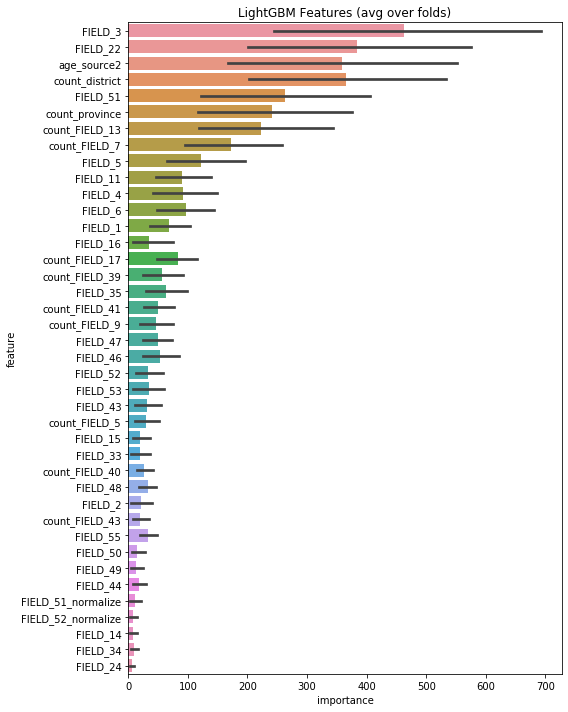

In [26]:
 feature_importance_df = kfold_lightgbm(concat_df, num_folds=10,submission_file_name = "data/sample_submission.csv", stratified = True)

In [23]:
concat_df = concat_df.drop(columns=["FIELD_10", "FIELD_13", "FIELD_17", "FIELD_18", "FIELD_19", "FIELD_20", "FIELD_23", "FIELD_25", "FIELD_26", "FIELD_27", "FIELD_28", "FIELD_29", "FIELD_30", "FIELD_31", "FIELD_36", "FIELD_37", "FIELD_38", "FIELD_39", "FIELD_40", "FIELD_41", "FIELD_42", "FIELD_45", "FIELD_7", "FIELD_8", "FIELD_9", "district", "province"])

# Build neural network

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Reshape, Dropout, Input, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

In [40]:
cat_features = ['province', 'district',
                'FIELD_7', 'FIELD_8', 'FIELD_9', 'FIELD_1', 'FIELD_2', 'FIELD_5',
                'FIELD_10', 'FIELD_13', 'FIELD_17', 
                'FIELD_24', 'FIELD_35', 'FIELD_39', 
                'FIELD_41', 'FIELD_42', 'FIELD_43',
                'FIELD_44', 'FIELD_16', 'FIELD_21', 'FIELD_32','FIELD_33', 'FIELD_34', 'FIELD_40', 'FIELD_45','FIELD_46']
bool_features = ['FIELD_18', 'FIELD_19', 
                 'FIELD_20', 'FIELD_23', 'FIELD_25', 
                 'FIELD_26', 'FIELD_27', 'FIELD_28', 
                 'FIELD_29', 'FIELD_30', 'FIELD_31', 
                 'FIELD_36', 'FIELD_37', 'FIELD_38', 
                 'FIELD_47', 'FIELD_48', 'FIELD_49']

In [41]:
df_train = df = pd.read_csv('data/train.csv', encoding='utf-8')
df_test = pd.read_csv('data/test.csv', encoding='utf-8')
num_features = [col for col in df_train.columns if col not in cat_features+bool_features if col not in ['label', 'id']]
print(num_features)

['age_source1', 'age_source2', 'maCv', 'FIELD_3', 'FIELD_4', 'FIELD_6', 'FIELD_11', 'FIELD_12', 'FIELD_14', 'FIELD_15', 'FIELD_22', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']


/Users/apple/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/apple/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Using Embedding instead one-hot encoding

In [42]:
df_train.replace(cleanup_nums, inplace=True)
df_test.replace(cleanup_nums, inplace=True)

In [43]:
df_train = cut_missing_fea(df_train)
df_test = cut_missing_fea(df_test)

In [44]:
concat_df = pd.concat([df_train, df_test])
concat_df.loc[concat_df['age_source1'] <18, 'age_source1'] = np.nan
concat_df.loc[concat_df['age_source2'] <18, 'age_source2'] = np.nan

/Users/apple/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [45]:
concat_df = impute_age(concat_df)

In [46]:
concat_df = concat_df.drop(columns=['age_source1'])
#not valid FIELD_12
concat_df = concat_df.drop(columns=['FIELD_12'])

In [47]:
cat_col = [col for col in  cat_features + bool_features if col in np.asarray(concat_df.columns)]

In [48]:
onehot_enc =[col for col in cat_col if len(list(df[col].unique()))<=6]

In [49]:
col_vals_dict = {c: list(concat_df[c].unique()) for c in onehot_enc}

In [50]:
concat_df = clean_boolean_value(concat_df)
concat_df = impute_numerical(concat_df, True)

['FIELD_18', 'FIELD_19', 'FIELD_20', 'FIELD_23', 'FIELD_25', 'FIELD_26', 'FIELD_27', 'FIELD_28', 'FIELD_29', 'FIELD_30', 'FIELD_31', 'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_47', 'FIELD_48', 'FIELD_49']
['age_source2', 'FIELD_3', 'FIELD_4', 'FIELD_6', 'FIELD_11', 'FIELD_14', 'FIELD_15', 'FIELD_22', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']
age_source2
31.0
FIELD_3
1453.0
FIELD_4
0.0
FIELD_6
0.0
FIELD_11
6.0
FIELD_14
0.0
FIELD_15
0.0
FIELD_22
23.0
FIELD_50
29.77
FIELD_51
33.814
FIELD_52
30.955
FIELD_53
31.171
FIELD_54
0.0
FIELD_55
0.11
FIELD_56
0.0
FIELD_57
0.0


In [51]:
embed_cols = []
len_embed_cols = []
for c in col_vals_dict:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        len_embed_cols.append(len(col_vals_dict[c]))
        print(c + ': %d values' % len(col_vals_dict[c])) #look at value counts to know the embedding dimensions
        
print('\n Number of embed features :', len(embed_cols))

FIELD_8: 3 values
FIELD_2: 3 values
FIELD_10: 4 values
FIELD_35: 6 values
FIELD_41: 7 values
FIELD_42: 3 values
FIELD_44: 3 values
FIELD_16: 6 values
FIELD_21: 4 values
FIELD_45: 5 values
FIELD_18: 3 values
FIELD_19: 3 values
FIELD_20: 3 values
FIELD_25: 3 values
FIELD_26: 3 values
FIELD_27: 3 values
FIELD_28: 3 values
FIELD_29: 3 values
FIELD_30: 3 values
FIELD_36: 4 values
FIELD_37: 3 values
FIELD_38: 3 values

 Number of embed features : 22


In [52]:
concat_df = encode_category(concat_df)

In [34]:
nb_numeric   = len(concat_df.columns) - len(col_vals_dict)
nb_categoric = len(col_vals_dict)
print('Number of Numerical features:', nb_numeric)
print('Number of Categorical features:', nb_categoric)


Number of Numerical features: 47
Number of Categorical features: 32


In [73]:
def build_embedding_network(len_embed_cols):
    
    model_out = []
    model_in  = []
    
    for dim in len_embed_cols:
        input_dim = Input(shape=(1,), dtype='int32')
        embed_dim = Embedding(dim, dim//2, input_length=1)(input_dim)
        embed_dim = Dropout(0.25)(embed_dim)
        embed_dim = Reshape((dim//2,))(embed_dim)
        model_out.append(embed_dim)
        model_in.append(input_dim)
    
    input_num = Input(shape=(49,), dtype='float32')
    outputs = Concatenate(axis=1)([*model_out, input_num])
    
    outputs = (Dense(256))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(0.2))(outputs)
    outputs = (Dense(128))(outputs)
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(64))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.2))(outputs)
    outputs = (Dense(1))(outputs)
    outputs = (Activation('sigmoid'))(outputs)
    
    model = Model([*model_in, input_num], outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [69]:
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        print(c)
        raw_vals = X_train[c].unique()
        print(raw_vals)
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

In [90]:
stratified = True
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve

num_folds = 10
runs_per_fold = 3
n_epochs = 3000
patience = 10

cv_aucs   = []
#     Divide in training/validation and test data
train_df = concat_df[concat_df['label'].notnull()]
test_df = concat_df[concat_df['label'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    # Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
full_val_preds = np.zeros(np.shape(train_df)[0])
y_preds = np.zeros((np.shape(test_df)[0],num_folds))
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['label','id', 'id_normalize', 'age_source1_normalize']]
    
for i, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['label'])):
    X_train_f, y_train_f = train_df[feats].iloc[train_idx], train_df['label'].iloc[train_idx]
    X_val_f, y_val_f = train_df[feats].iloc[valid_idx], train_df['label'].iloc[valid_idx]
        
    X_test_f = test_df.copy()
        # Shuffle data
    idx = np.arange(len(X_train_f))
    np.random.shuffle(idx)
    X_train_f = X_train_f.iloc[idx]
    y_train_f = y_train_f.iloc[idx]

    proc_X_train_f, proc_X_val_f, proc_X_test_f = preproc(X_train_f, X_val_f, X_test_f) 
    val_preds = 0
    for j in range(runs_per_fold):
    
        NN = build_embedding_network(len_embed_cols)

        # Set callback functions to early stop training and save the best model so far
        callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]

        NN.fit(proc_X_train_f, y_train_f.values, epochs=n_epochs, batch_size=256, verbose=1,callbacks=callbacks,validation_data=(proc_X_val_f, y_val_f))
        
        val_preds += NN.predict(proc_X_val_f)[:,0] / runs_per_fold
        y_preds[:,i] += NN.predict(proc_X_test_f)[:,0] / runs_per_fold
        
    full_val_preds[valid_idx] += val_preds
        
    cv_auc  = roc_auc_score(y_val_f.values, val_preds)
    cv_aucs.append(cv_auc)
    print ('\nFold %i prediction cv AUC: %.5f\n' %(i,cv_auc))
    
    print('Mean out of fold AUC: %.5f' % np.mean(cv_auc))
#     print('Full validation AUC: %.5f' % roc_auc_score(y_train.values, full_val_preds))

Starting LightGBM. Train shape: (30000, 73), test shape: (20000, 73)
FIELD_8
[nan  0.  1.]
FIELD_2
[ 1.  0. nan]
FIELD_10
[nan 'GH' 'T1']
FIELD_35
[nan  3.  2.  4.  0.  1.]
FIELD_41
[nan 1.0 2.0 3.0 5.0 4.0]
FIELD_42
[nan 0.0 1.0]
FIELD_44
[nan  2.  1.]
FIELD_16
[nan  1.  2.  3.  4.  5.]
FIELD_21
[nan  1.  0.  2.]
FIELD_45
[nan 2.0 1.0]
FIELD_18
[nan 0 1]
FIELD_19
[nan 0 1]
FIELD_20
[nan 0 1]
FIELD_25
[nan 1 0]
FIELD_26
[nan 1 0]
FIELD_27
[nan 1 0]
FIELD_28
[nan 1 0]
FIELD_29
[nan 0 1]
FIELD_30
[nan 0 1]
FIELD_36
[nan  0.  1.]
FIELD_37
[nan 1 0]
FIELD_38
[nan 0 1]
Train on 26999 samples, validate on 3001 samples
Epoch 1/3000
26999/26999 [==============================] - 4s 137us/step - loss: 30.4898 - val_loss: 1.7130
Epoch 2/3000
26999/26999 [==============================] - 1s 31us/step - loss: 2.6106 - val_loss: 0.1356
Epoch 3/3000
26999/26999 [==============================] - 1s 30us/step - loss: 0.5347 - val_loss: 0.1170
Epoch 4/3000
26999/26999 [==============================]

26999/26999 [==============================] - 1s 33us/step - loss: 0.1558 - val_loss: 0.0974
Epoch 13/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.1756 - val_loss: 0.1205
Epoch 14/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.1471 - val_loss: 0.1045
Epoch 15/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.1708 - val_loss: 0.0935
Epoch 16/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.1279 - val_loss: 0.0914
Epoch 17/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.1229 - val_loss: 0.0899
Epoch 18/3000
26999/26999 [==============================] - 1s 31us/step - loss: 0.1343 - val_loss: 0.0900
Epoch 19/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.1206 - val_loss: 0.0904
Epoch 20/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.1163 - val_loss: 0.0921
Epoch 21/3000
26999/26999 [===============

26999/26999 [==============================] - 1s 34us/step - loss: 0.0915 - val_loss: 0.0839
Epoch 53/3000
26999/26999 [==============================] - 1s 34us/step - loss: 0.0875 - val_loss: 0.0862
Epoch 54/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.0846 - val_loss: 0.0852
Epoch 55/3000
26999/26999 [==============================] - 1s 34us/step - loss: 0.0895 - val_loss: 0.0857
Epoch 56/3000
26999/26999 [==============================] - 1s 34us/step - loss: 0.0868 - val_loss: 0.0872
Epoch 57/3000
26999/26999 [==============================] - 1s 34us/step - loss: 0.0924 - val_loss: 0.0880
Epoch 58/3000
26999/26999 [==============================] - 1s 34us/step - loss: 0.0864 - val_loss: 0.0857
Epoch 59/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.0876 - val_loss: 0.0852
Epoch 60/3000
26999/26999 [==============================] - 1s 33us/step - loss: 0.0876 - val_loss: 0.0843
Epoch 61/3000
26999/26999 [===============

Epoch 19/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.1162 - val_loss: 0.1080
Epoch 20/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.1114 - val_loss: 0.0892
Epoch 21/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.1127 - val_loss: 0.0882
Epoch 22/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.1118 - val_loss: 0.0876
Epoch 23/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.1027 - val_loss: 0.0863
Epoch 24/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.1170 - val_loss: 0.0843
Epoch 25/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.1082 - val_loss: 0.0878
Epoch 26/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.1007 - val_loss: 0.0863
Epoch 27/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.1034 - val_loss: 0.0835
Epoch 28/3000
26999/26999 [=

26999/26999 [==============================] - 1s 34us/step - loss: 0.0861 - val_loss: 0.0821
Epoch 55/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.0933 - val_loss: 0.0854
Epoch 56/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.0865 - val_loss: 0.0827
Epoch 57/3000
26999/26999 [==============================] - 1s 35us/step - loss: 0.0882 - val_loss: 0.0858
Epoch 58/3000
26999/26999 [==============================] - 1s 34us/step - loss: 0.0862 - val_loss: 0.0824

Fold 2 prediction cv AUC: 0.59923

Mean out of fold AUC: 0.59923
FIELD_8
[nan  0.  1.]
FIELD_2
[ 0.  1. nan]
FIELD_10
[nan 'GH' 'T1']
FIELD_35
[nan  0.  1.  4.  3.  2.]
FIELD_41
[nan 1.0 2.0 5.0 3.0 4.0]
FIELD_42
[nan 0.0 1.0]
FIELD_44
[nan  1.  2.]
FIELD_16
[nan  1.  2.  3.  4.  5.]
FIELD_21
[nan  1.  2.  0.]
FIELD_45
[nan 1.0 2.0]
FIELD_18
[nan 0 1]
FIELD_19
[nan 0 1]
FIELD_20
[nan 0 1]
FIELD_25
[nan 1 0]
FIELD_26
[nan 1 0]
FIELD_27
[nan 1 0]
FIELD_28
[nan 1 0]
FIELD

Epoch 34/3000
26999/26999 [==============================] - 1s 37us/step - loss: 0.0899 - val_loss: 0.0844
Epoch 35/3000
26999/26999 [==============================] - 1s 37us/step - loss: 0.0902 - val_loss: 0.0962
Epoch 36/3000
26999/26999 [==============================] - 1s 37us/step - loss: 0.0913 - val_loss: 0.0839
Epoch 37/3000
26999/26999 [==============================] - 1s 37us/step - loss: 0.0949 - val_loss: 0.0850
Epoch 38/3000
26999/26999 [==============================] - 1s 37us/step - loss: 0.0954 - val_loss: 0.0868
Epoch 39/3000
26999/26999 [==============================] - 1s 37us/step - loss: 0.0900 - val_loss: 0.0826
Epoch 40/3000
26999/26999 [==============================] - 1s 37us/step - loss: 0.0877 - val_loss: 0.0837
Train on 26999 samples, validate on 3001 samples
Epoch 1/3000
26999/26999 [==============================] - 6s 219us/step - loss: 46.3011 - val_loss: 4.6432
Epoch 2/3000
26999/26999 [==============================] - 1s 38us/step - loss: 5.995

Epoch 9/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.1412 - val_loss: 0.0982
Epoch 10/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.1422 - val_loss: 0.0965
Epoch 11/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.1268 - val_loss: 0.0954
Epoch 12/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.1141 - val_loss: 0.0970
Epoch 13/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.1156 - val_loss: 0.1027
Epoch 14/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.1196 - val_loss: 0.0911
Epoch 15/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.1130 - val_loss: 0.0949
Epoch 16/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.1036 - val_loss: 0.1243
Epoch 17/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.1144 - val_loss: 0.1004
Epoch 18/3000
27000/27000 [==

27000/27000 [==============================] - 1s 38us/step - loss: 0.1019 - val_loss: 0.0882
Epoch 49/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0887 - val_loss: 0.0883
Epoch 50/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0872 - val_loss: 0.0854
Epoch 51/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0881 - val_loss: 0.0850
Epoch 52/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0874 - val_loss: 0.0852
Epoch 53/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0868 - val_loss: 0.0855
Epoch 54/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0864 - val_loss: 0.0847
Epoch 55/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0867 - val_loss: 0.0897
Epoch 56/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0881 - val_loss: 0.0841
Epoch 57/3000
27000/27000 [===============

27000/27000 [==============================] - 1s 39us/step - loss: 0.1059 - val_loss: 0.0902
Epoch 33/3000
27000/27000 [==============================] - 1s 39us/step - loss: 0.0938 - val_loss: 0.0860
Epoch 34/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0969 - val_loss: 0.0859
Epoch 35/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0951 - val_loss: 0.0864
Epoch 36/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0896 - val_loss: 0.0893
Epoch 37/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0934 - val_loss: 0.0965
Epoch 38/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0941 - val_loss: 0.0892
Epoch 39/3000
27000/27000 [==============================] - 1s 38us/step - loss: 0.0894 - val_loss: 0.0861
Epoch 40/3000
27000/27000 [==============================] - 1s 39us/step - loss: 0.0949 - val_loss: 0.0921
Epoch 41/3000
27000/27000 [===============

Epoch 14/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.1247 - val_loss: 0.0973
Epoch 15/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.1420 - val_loss: 0.0903
Epoch 16/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.1137 - val_loss: 0.0947
Epoch 17/3000
27001/27001 [==============================] - 1s 42us/step - loss: 0.1346 - val_loss: 0.0926
Epoch 18/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.1173 - val_loss: 0.0896
Epoch 19/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.1139 - val_loss: 0.0819
Epoch 20/3000
27001/27001 [==============================] - 1s 40us/step - loss: 0.1348 - val_loss: 0.0877
Epoch 21/3000
27001/27001 [==============================] - 1s 40us/step - loss: 0.1108 - val_loss: 0.0866
Epoch 22/3000
27001/27001 [==============================] - 1s 40us/step - loss: 0.1142 - val_loss: 0.0871
Epoch 23/3000
27001/27001 [=

27001/27001 [==============================] - 1s 41us/step - loss: 0.0970 - val_loss: 0.0826
Epoch 26/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.0975 - val_loss: 0.0830
Epoch 27/3000
27001/27001 [==============================] - 1s 40us/step - loss: 0.0996 - val_loss: 0.0823
Epoch 28/3000
27001/27001 [==============================] - 1s 40us/step - loss: 0.0985 - val_loss: 0.0861
Epoch 29/3000
27001/27001 [==============================] - 1s 40us/step - loss: 0.0943 - val_loss: 0.0963
Epoch 30/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.0952 - val_loss: 0.0817
Epoch 31/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.0922 - val_loss: 0.0824
Epoch 32/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.0911 - val_loss: 0.0824
Epoch 33/3000
27001/27001 [==============================] - 1s 41us/step - loss: 0.0914 - val_loss: 0.0843
Epoch 34/3000
27001/27001 [===============

Epoch 30/3000
27001/27001 [==============================] - 1s 43us/step - loss: 0.0973 - val_loss: 0.0894
Epoch 31/3000
27001/27001 [==============================] - 1s 42us/step - loss: 0.0994 - val_loss: 0.0855
Epoch 32/3000
27001/27001 [==============================] - 1s 42us/step - loss: 0.0941 - val_loss: 0.0869
Epoch 33/3000
27001/27001 [==============================] - 1s 42us/step - loss: 0.0952 - val_loss: 0.0840
Epoch 34/3000
27001/27001 [==============================] - 1s 42us/step - loss: 0.0960 - val_loss: 0.0821
Epoch 35/3000
27001/27001 [==============================] - 1s 42us/step - loss: 0.0962 - val_loss: 0.0871
Epoch 36/3000
27001/27001 [==============================] - 1s 42us/step - loss: 0.0937 - val_loss: 0.0817
Epoch 37/3000
27001/27001 [==============================] - 1s 43us/step - loss: 0.0938 - val_loss: 0.0822
Epoch 38/3000
27001/27001 [==============================] - 1s 42us/step - loss: 0.0928 - val_loss: 0.0849
Epoch 39/3000
27001/27001 [=

Epoch 6/3000
27001/27001 [==============================] - 1s 44us/step - loss: 0.2796 - val_loss: 0.1295
Epoch 7/3000
27001/27001 [==============================] - 1s 44us/step - loss: 0.2517 - val_loss: 0.1066
Epoch 8/3000
27001/27001 [==============================] - 1s 44us/step - loss: 0.2045 - val_loss: 0.1034
Epoch 9/3000
27001/27001 [==============================] - 1s 44us/step - loss: 0.2003 - val_loss: 0.1037
Epoch 10/3000
27001/27001 [==============================] - 1s 44us/step - loss: 0.1561 - val_loss: 0.0952
Epoch 11/3000
27001/27001 [==============================] - 1s 44us/step - loss: 0.1825 - val_loss: 0.0907
Epoch 12/3000
27001/27001 [==============================] - 1s 44us/step - loss: 0.1710 - val_loss: 0.0935
Epoch 13/3000
27001/27001 [==============================] - 1s 44us/step - loss: 0.1354 - val_loss: 0.0969
Epoch 14/3000
27001/27001 [==============================] - 1s 44us/step - loss: 0.1384 - val_loss: 0.0901
Epoch 15/3000
27001/27001 [=====

27001/27001 [==============================] - 1s 46us/step - loss: 0.0861 - val_loss: 0.0828
Epoch 58/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.0879 - val_loss: 0.0837
Epoch 59/3000
27001/27001 [==============================] - 1s 45us/step - loss: 0.0887 - val_loss: 0.0833
Epoch 60/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.0865 - val_loss: 0.0828
Epoch 61/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.0858 - val_loss: 0.0852
Epoch 62/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.0857 - val_loss: 0.0841
Epoch 63/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.0926 - val_loss: 0.0832
Epoch 64/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.0862 - val_loss: 0.0863
Epoch 65/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.0858 - val_loss: 0.0838

Fold 8 prediction cv AUC: 0.54198

Mean o

Epoch 15/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.1080 - val_loss: 0.0927
Epoch 16/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.1091 - val_loss: 0.0842
Epoch 17/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.1095 - val_loss: 0.1144
Epoch 18/3000
27001/27001 [==============================] - 1s 45us/step - loss: 0.1064 - val_loss: 0.0958
Epoch 19/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.1106 - val_loss: 0.0892
Epoch 20/3000
27001/27001 [==============================] - 1s 45us/step - loss: 0.1001 - val_loss: 0.0827
Epoch 21/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.1019 - val_loss: 0.0916
Epoch 22/3000
27001/27001 [==============================] - 1s 46us/step - loss: 0.0997 - val_loss: 0.0849
Epoch 23/3000
27001/27001 [==============================] - 1s 47us/step - loss: 0.0978 - val_loss: 0.0862
Epoch 24/3000
27001/27001 [=

In [85]:
kfold_neuralNetwork(concat_df, 10, submission_file_name = "data/sample_submission.csv", stratified = True)

Starting LightGBM. Train shape: (30000, 73), test shape: (20000, 73)
FIELD_8
[ 0. nan  1.]
FIELD_2
[ 1.  0. nan]
FIELD_10
['T1' nan 'GH']
FIELD_35
[ 1. nan  0.  4.  2.  3.]
FIELD_41
[1.0 nan 5.0 2.0 3.0 4.0]
FIELD_42
[0.0 nan 1.0]
FIELD_44
[ 1. nan  2.]
FIELD_16
[ 2. nan  1.  3.  4.  5.]
FIELD_21
[ 1. nan  2.  0.]
FIELD_45
[1.0 nan 2.0]
FIELD_18
[1 nan 0]
FIELD_19
[0 nan 1]
FIELD_20
[0 nan 1]
FIELD_25
[1 nan 0]
FIELD_26
[0 nan 1]
FIELD_27
[1 nan 0]
FIELD_28
[1 nan 0]
FIELD_29
[0 nan 1]
FIELD_30
[1 nan 0]
FIELD_36
[ 0. nan  1.]
FIELD_37
[1 nan 0]
FIELD_38
[0 nan 1]
Train on 26999 samples, validate on 3001 samples
Epoch 1/3000
26999/26999 [==============================] - 3s 98us/step - loss: 31.6898 - val_loss: 2.6426
Epoch 2/3000
26999/26999 [==============================] - 1s 28us/step - loss: 3.4716 - val_loss: 0.1885
Epoch 3/3000
26999/26999 [==============================] - 1s 27us/step - loss: 0.7827 - val_loss: 0.1093
Epoch 4/3000
26999/26999 [==============================] 

Epoch 42/3000
26999/26999 [==============================] - 1s 26us/step - loss: 0.0909 - val_loss: 0.0920
Epoch 43/3000
26999/26999 [==============================] - 1s 25us/step - loss: 0.0963 - val_loss: 0.0858
Epoch 44/3000
26999/26999 [==============================] - 1s 27us/step - loss: 0.0932 - val_loss: 0.0859
Epoch 45/3000
26999/26999 [==============================] - 1s 25us/step - loss: 0.0899 - val_loss: 0.0871
Epoch 46/3000
26999/26999 [==============================] - 1s 25us/step - loss: 0.0905 - val_loss: 0.0918
Epoch 47/3000
26999/26999 [==============================] - 1s 27us/step - loss: 0.0897 - val_loss: 0.0867
Epoch 48/3000
26999/26999 [==============================] - 1s 25us/step - loss: 0.0931 - val_loss: 0.0924
Train on 26999 samples, validate on 3001 samples
Epoch 1/3000
26999/26999 [==============================] - 3s 113us/step - loss: 36.9452 - val_loss: 5.0984
Epoch 2/3000
26999/26999 [==============================] - 1s 30us/step - loss: 6.700

NameError: name 'outf_ind' is not defined

In [58]:
print('FIELD_13' in np.asarray(concat_df.columns))

True


In [59]:
concat_df = concat_df.drop(columns=['FIELD_13', 'FIELD_7', 'FIELD_9', 'district', 'province'])

In [65]:
print(concat_df['FIELD_8'].unique())

[nan 'MALE' 'FEMALE']


In [76]:
concat_df = concat_df.replace({"FIELD_8": {"MALE": 1, "FEMALE": 0}, "FIELD_36": {'None': np.nan}})

In [80]:
# concat_df.head()
concat_df.drop(columns=["FIELD_10"])

FIELD_1  FIELD_11  FIELD_14  FIELD_15  FIELD_16 FIELD_18 FIELD_19  \
0            1       6.0         1         1       NaN      NaN      NaN   
1            1      12.0         0         0       2.0        1        1   
2            0      12.0         0         0       1.0        0        0   
3            0       6.0         1         1       NaN      NaN      NaN   
4            0      12.0         0         0       1.0        1        1   
...        ...       ...       ...       ...       ...      ...      ...   
19995        1      12.0         0         0       2.0        1        0   
19996        1       6.0         1         1       NaN      NaN      NaN   
19997        1       6.0         1         1       NaN      NaN      NaN   
19998        1       0.0         0         0       1.0        0        1   
19999        1       0.0         0         0       1.0        1        0   

       FIELD_2 FIELD_20  FIELD_21  ...  FIELD_55_normalize FIELD_56_normalize  \
0          1.0      NaN       NaN  ...                0.11                0.0   
1          0.0        1       1.0  ...                0.04                0.0   
2          1.0        0       1.0  ...                0.16                0.0   
3          1.0      NaN       NaN  ...                0.11                0.0   
4          1.0        1       1.0  ...                0.03                0.0   
...        ...      ...       ...  ...                 ...                ...   
19995      1.0        0       1.0  ...                0.14                0.0   
19996      1.0      NaN       NaN  ...                0.11                0.0   
19997      1.0      NaN       NaN  ...                0.11                0.0   
19998      1.0        1       1.0  ...                0.16                0.0   
19999      1.0        0       1.0  ...                0.12                0.0   

      FIELD_57_normalize count_province count_district count_FIELD_7  \
0                    0.0            NaN            NaN       21219.0   
1                    0.0         1726.0          530.0          34.0   
2                    0.0         1726.0          184.0           2.0   
3                    0.0          150.0           42.0           1.0   
4                    0.0         3939.0           81.0          13.0   
...                  ...            ...            ...           ...   
19995                0.0          434.0           79.0         597.0   
19996                0.0            NaN            NaN       21219.0   
19997                0.0            NaN            NaN       21219.0   
19998                0.0          225.0           11.0           1.0   
19999                0.0            NaN            NaN       21219.0   

      count_FIELD_9  count_FIELD_5 count_FIELD_13 count_FIELD_41  
0               NaN        20745.0            NaN            NaN  
1            7961.0         5070.0         7973.0         7981.0  
2           18369.0         4830.0         8285.0        21508.0  
3               NaN         5070.0            NaN            NaN  
4            7961.0         7799.0         7973.0         7981.0  
...             ...            ...            ...            ...  
19995       18369.0         5656.0         8285.0        21508.0  
19996           NaN        20745.0            NaN            NaN  
19997           NaN        20745.0            NaN            NaN  
19998       18369.0         7799.0         8285.0        21508.0  
19999       18369.0        20745.0         8285.0        21508.0  

[50000 rows x 72 columns]

In [82]:
num_cols = [x for x in concat_df.columns if x not in embed_cols if x not in ['label', 'id']]


# Impute missing values in order to scale
concat_df[num_cols] = concat_df[num_cols].fillna(value = 0)
# X_test[num_cols] = X_test[num_cols].fillna(value = 0)

In [91]:
test_df['label'] = np.mean(y_preds, axis=1)
test = test_df[['id', 'label']]
out_df = pd.DataFrame({'id': test['id'], 'label': test['label']})
out_df.to_csv('nn_embedding_submission.csv', index=False)

/Users/apple/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Result Max ping for test_2: 0.21475